In [ ]:
import os
RUN_PLATFORM = os.getenv("RUN_PLATFORM") or "LOCAL"
if RUN_PLATFORM == "LOCAL":
	# Make sure that when not in docker, packages are installed
	!pip install -r requirements.txt
	data_dir = "data"
elif RUN_PLATFORM == "KAGGLE":
	data_dir = ""
metadata_path = os.path.join(data_dir, "train_metadata.csv")
audio_dir = os.path.join(data_dir, "train_audio")
spectrogram_dir = os.path.join(data_dir, "train_spectogram")
os.makedirs(spectrogram_dir, exist_ok=True)
spectrogram_metadata_path = os.path.join(data_dir, "train_spectrogram.csv")

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
	# avoid rare bugs when image won't plot
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pytorch_lightning as pl
from pytorch_lightning import Trainer

# loads .env file into runtime env vars
import os.path
if not os.path.isfile(".env"):
	raise Exception(".env must be created by copying .env.template and filling out the values")
from dotenv import load_dotenv
load_dotenv()

import wandb
#wandb.login() # TODO remove comment when needed

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

# make it not fail in terminal execution
from IPython.display import display
from IPython.display import Audio
from tqdm.notebook import tqdm

from types import SimpleNamespace
	# make dict to class
import pathlib
import platform

from sklearn.model_selection import train_test_split

# Audio process
import librosa
import librosa.display
import cv2

# Threading
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: asztrikx (asztrikx-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
d:\File\Study\BME\Msc\Haladó adatelemzés laboratórium\nhf\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Hyperparameter configuration, set random states

In [9]:
# hyperparameters
random_state = 42 # random state
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
num_workers = 2 # number of workers for data loading
batch_size = 128

eval_only = True
is_score_on = True
visualize_and_analyze = True

# Faster exec. on newer GPUs
torch.set_float32_matmul_precision('medium')

# Fix random early on
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state);

## Metadata csv

In [ ]:
metadata = pd.read_csv(metadata_path)

## Transform data (Cached)

In [ ]:
def process_sound_file(file_path, save_dir, segment_length=3, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
	y, sr = librosa.load(file_path, sr=sr)

	segment_samples = sr * segment_length
	num_segments = int(np.ceil(len(y) / segment_samples))

	spectrograms = []
	for i in range(num_segments):
		start = i * segment_samples
		end = start + segment_samples
		segment = y[start:end]

		#TODO how should padding work
		if len(segment) < segment_samples:
			if num_segments == 1:
				segment = np.pad(segment, (0, segment_samples - len(segment)), mode='wrap')
			else:
				missing_length = segment_samples - len(segment)
				segment = np.concatenate((segment, y[:missing_length]))
		mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
		mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

		mel_spec_resized = cv2.resize(mel_spec_db, (128, 128)) # TODO n_mels?

		image_filename = f"{os.path.basename(file_path).replace('.ogg', '')}_seg{i}.png"
		image_path = os.path.join(save_dir, image_filename)
		plt.imsave(image_path, mel_spec_resized, cmap='inferno')

		spectrograms.append(image_path)

	return spectrograms

if not os.path.isfile(spectrogram_metadata_path):
	data = []
	metadata = metadata.iloc[0:2] # TODO avoid ssd murder until figured out

	# Create subdirs outside of loop
	for species in metadata["primary_label"].unique():
		os.makedirs(os.path.join(spectrogram_dir, species), exist_ok=True)

	with tqdm(total=len(metadata)) as pbar:
		with ThreadPoolExecutor() as executor:
			def get_spectrogram(filename):
				audio_path = os.path.join(audio_dir, filename)
				species = filename.split('/')[0]

				out_path = os.path.join(spectrogram_dir, species)
				audio_spectrograms = process_sound_file(audio_path, out_path, sr=32000)

				return audio_spectrograms

			futures = {
				executor.submit(get_spectrogram, filename): filename
				for filename in metadata["filename"]
			}
			for future in concurrent.futures.as_completed(futures):
				filename = futures[future]
				audio_spectrograms = future.result()

				# Get other data from metadata: do not do this in Dataset for caching
				row = metadata[metadata["filename"] == filename]
				latitude = row["latitude"].values[0]
				longitude = row["longitude"].values[0]
				author = row["author"].values[0]

				label = species

				for audio_spectrogram in audio_spectrograms:
					audio_spectrogram = os.path.relpath(audio_spectrogram, spectrogram_dir)
					data.append((filename, audio_spectrogram, label, author, latitude, longitude))
				pbar.update(1)

	spectrogram_df = pd.DataFrame(data, columns=["audio_path", "spectrogram_path", "label", "author", "latitude", "longitude"])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualize 1 audio file's spectrograms

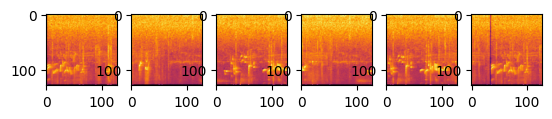

In [52]:
first_spectrograms = spectrogram_df[spectrogram_df["audio_path"] == spectrogram_df.iloc[0]["audio_path"]]
first_spectrograms_paths = first_spectrograms["spectrogram_path"].sort_values(ascending=True)

fig, ax = plt.subplots(1, len(first_spectrograms_paths))
for i, first_spectrograms_path in enumerate(first_spectrograms_paths):
	fullpath = os.path.join(spectrogram_dir, first_spectrograms_path)

	ax[i].imshow(mpimg.imread(fullpath))

## Custom Dataset

In [ ]:
class BirdsDataset(Dataset):
	# override
	def __init__(self, csv, transform = None, target_transform = None):
		self.df = pd.read_csv(csv)
		self.transform = transform
		self.target_transform = target_transform

	# override
	def __len__(self):
		return len(self.df)

	# override
	def __getitem__(self, index):
		image_path = self.df.iloc[index]["spectrogram_path"]
		audio = read_image(image_path)

		label = {
			"label": self.df.iloc[index]["label"],
			"latitude": self.df.iloc[index]["latitude"],
			"longitude": self.df.iloc[index]["longitude"],
			"author": self.df.iloc[index]["author"],
		}
		
		if self.transform:
			audio = self.transform(audio)
		if self.target_transform:
			label = self.target_transform(label)
		return audio, label

## Data module

In [ ]:
class BirdsDataModule(pl.LightningDataModule):
	def __init__(self, batch_size):
		super().__init__()
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			# TODO
		])
		self.reverse_transform = transforms.Compose([
			# TODO
		])

		self.dataset_notransform = BirdsDataset(spectrogram_metadata_path, transform = None)
		self.dataset = BirdsDataset(spectrogram_metadata_path, transform = self.base_transform)

	# override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test

	# override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	# override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

birds_dm = BirdsDataModule(batch_size)
birds_dm.prepare_data()
birds_dm.setup()

## Data visualization

## Data analysis

## Metrics

## Baseline

## Model